In [1]:
import neuromaps
print("neuromaps version:", neuromaps.__version__)

neuromaps version: 0.0.5+41.gf0ed67c


In [2]:
## run if needed
# pip install neuromaps brainspace
# pip install statsmodels

In [3]:
# Add more imports if needed

from neuromaps.datasets import fetch_atlas ## used to access the templates for the coordinate system
import nibabel as nib ## used to load system dictionary per key
from neuromaps.datasets import available_annotations ## repository of brain maps - spatial maps representing some
from neuromaps.datasets import available_tags ## most annotations have “tags” that help to describe the data they represent
from neuromaps.datasets import fetch_annotation
from neuromaps.datasets import fetch_fsaverage

from neuromaps import transforms
import netneurotools
# possibly need
from netneurotools import datasets as nntdata
from neuromaps import parcellate
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
# plotting 
from neuromaps.images import load_data
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from neuromaps import plotting
from nilearn import plotting
import numpy as np
import pandas as pd
# sampling
from neuromaps import datasets, images, nulls, resampling
from neuromaps.resampling import resample_images
from neuromaps.stats import compare_images
from neuromaps import stats
from nilearn.datasets import fetch_atlas_surf_destrieux
from neuromaps.nulls import alexander_bloch
from neuromaps.stats import compare_images
from scipy.stats import pearsonr

from nilearn.surface import load_surf_mesh
from brainspace.null_models import SpinPermutations
from nilearn.surface import InMemoryMesh, PolyMesh
from nilearn.surface import SurfaceImage
from nilearn.plotting import view_surf

import time
# from neuromaps.stats import fdr_correct ## doesn't work?
# for FDR
from statsmodels.stats.multitest import multipletests

In [4]:
# for annotation in available_annotations():
#     print(annotation)

### Our Source Map

In [5]:
## note this map is 164k density
evo_map = fetch_annotation(source='hill2010', desc='evoexp', space='fsLR', den='164k')
print(evo_map)
# evo map is string where data for this brain map is stored


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'evoexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    
/Users/kevin/neuromaps-data/annotations/hill2010/evoexp/fsLR/source-hill2010_desc-evoexp_space-fsLR_den-164k_hemi-R_feature.func.gii


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/3660410277.py:39: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/3660410277.py:46: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


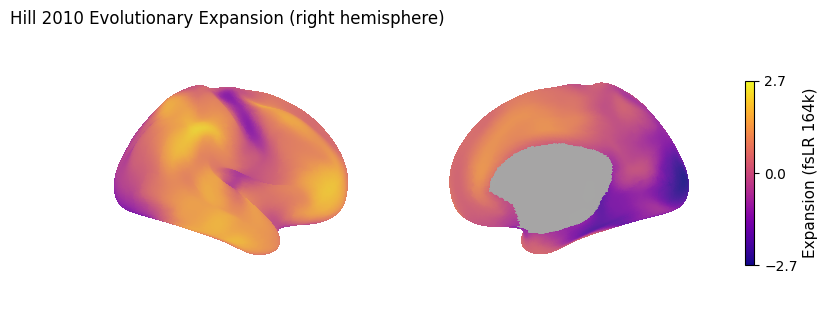

In [6]:
from nilearn import plotting
from neuromaps import plotting

# fig = plotting.plot_surf_template(
#     data=evo_map,
#     template='fsLR',
#     density='164k',
#     surf='inflated',          
#     cmap='plasma',
#     hemi='R',
#     colorbar=True,
# )
# fig.suptitle("Evolutionary Expansion (Hill et al., 2010)", fontsize=16, y=0.9)
# fig.show()

rh_data = load_data(evo_map)

# fetches brain surface options for plotting
fslr = fetch_atlas('fsLR', density='164k')
surf_r = fslr['inflated'].R

vmin, vmax = -2.7, 2.7

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_kwargs = dict(
    surf_mesh=surf_r,
    surf_map=rh_data,
    hemi='right',
    cmap='plasma',
    bg_on_data=True,
    vmin=vmin,
    vmax=vmax,
    colorbar=False
)
# plot right veiw
plotting.plot_surf(
    view='lateral',
    axes=ax1,
    title='Hill 2010 Evolutionary Expansion (right hemisphere)',
    **plot_kwargs
)
# plot from left view
plotting.plot_surf(
    view='medial',
    axes=ax2,
    **plot_kwargs
)

sm = plt.cm.ScalarMappable(cmap='plasma')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Expansion (fsLR 164k)', fontsize=11)
cbar.set_ticks([-2.7, 0, 2.7])

plt.show()

### Target Maps
There are 12
1. PC1 Gene Expression
2. T1w/T2w ratio (Myelin)
3. Cortical Thickness
4. Developmental expansion
5. Functional gradient
6. Intersubject variability
7. Cerebral blood flow
8. Cerebral blood volume
9. Oxygen metabolism
10. Glucose metabolism
11. Allometric scaling NIH
12. Allometric scaling PNC

In [8]:
# Kevin S will be working with these
('abagen', 'genepc1', 'fsaverage', '10k') # PC1 gene expression
('hcps1200', 'myelinmap', 'fsLR', '32k') # myelin maps - T1w/T2w ratio
('hcps1200', 'thickness', 'fsLR', '32k') # cortical thickness
('hill2010', 'devexp', 'fsLR', '164k') # dev expansion
('margulies2016', 'fcgradient01', 'fsLR', '32k') # functional development
('mueller2013', 'intersubjvar', 'fsLR', '164k') # intersubject functional variability
# Kevin H will be working with these
('raichle', 'cbf', 'fsLR', '164k') # cerebral blood flow
('raichle', 'cbv', 'fsLR', '164k') # cerebral blood volume
('raichle', 'cmr02', 'fsLR', '164k') # oxygen metabolism CMRO2
('raichle', 'cmrglc', 'fsLR', '164k') # glucose metabolism GMRGlu
('reardon2018', 'scalingpnc', 'civet', '41k') #  allometric scaling PNC
('reardon2018', 'scalingnih', 'civet', '41k') # allometric scaling NIH

('reardon2018', 'scalingnih', 'civet', '41k')

In [9]:
genepc1 = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2682030449.py:39: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2682030449.py:50: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


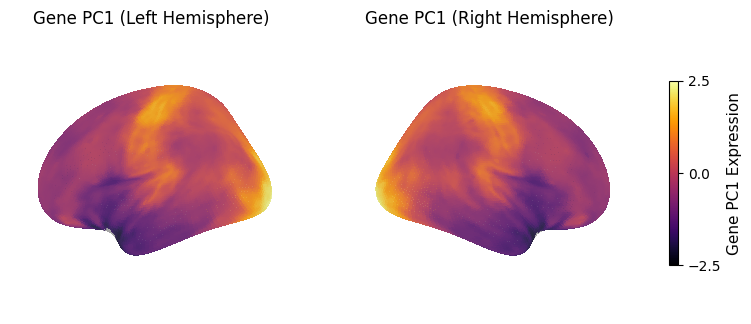

In [10]:
# from nilearn import plotting
# from neuromaps import plotting
# # neuromaps
# fig = plotting.plot_surf_template(
#     data=genepc1,
#     template='fsaverage',
#     density='10k',
#     surf='inflated',          
#     cmap='inferno',
#     hemi='R',
#     colorbar=True
# )
# fig.suptitle("Gene PC1 Expression (fsaverage 10k)", fontsize=16, y=0.9)
# fig.show()

# Gene PC1 brain map plotting

# fetch brain meshes of density 10k for plotting
fsavg = fetch_fsaverage(density='10k')

# load data from GIFTI files
lh_data = load_data(genepc1[0])
rh_data = load_data(genepc1[1])

vmin, vmax = -2.5, 2.5   # adjust if needed for better contrast

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_kwargs = dict(
    cmap='inferno',
    bg_on_data=True,
    vmin=vmin, vmax=vmax,
    colorbar=False
)

# left hemi
plotting.plot_surf(
    surf_mesh=fsavg['inflated'].L,
    surf_map=lh_data,
    hemi='left',
    view='lateral',
    axes=ax1,
    title='Gene PC1 (Left Hemisphere)',
    **plot_kwargs
)

# right hemi
plotting.plot_surf(
    surf_mesh=fsavg['inflated'].R,
    surf_map=rh_data,
    hemi='right',
    view='lateral',
    axes=ax2,
    title='Gene PC1 (Right Hemisphere)',
    **plot_kwargs
)
# colorbar for both plots
sm = plt.cm.ScalarMappable(cmap='inferno')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Gene PC1 Expression', fontsize=11)
cbar.set_ticks([vmin, 0, vmax])

plt.show()

In [11]:
## first 6 target maps
# fetches the string of file paths for each map
T1w_T2w_ratio = fetch_annotation(source='hcps1200', desc='myelinmap',space='fsLR', den='32k')
cortical_thickness = fetch_annotation(source= 'hcps1200', desc= 'thickness', space='fsLR', den='32k')
dev_expansion = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
func_gradient = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
intersub_var = fetch_annotation(source='mueller2013', desc='intersubjvar', space='fsLR', den='164k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  

In [12]:
# # plotting for T1w/T2w ratio
# data = load_data(T1w_T2w_ratio)
# vmin, vmax = np.percentile(data[~np.isnan(data)], [3, 98])

# # Plot with adjusted limits
# fig = plotting.plot_surf_template(
#     data=T1w_T2w_ratio,
#     template='fsLR',
#     density='32k',
#     surf='inflated',
#     cmap='viridis', 
#     hemi='R',
#     colorbar=True,
#     vmin=vmin,
#     vmax=vmax
# )
# fig.suptitle("T1w/T2w Ratio (fsLR 32k)")
# fig.show()

/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2581755089.py:17: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2581755089.py:32: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


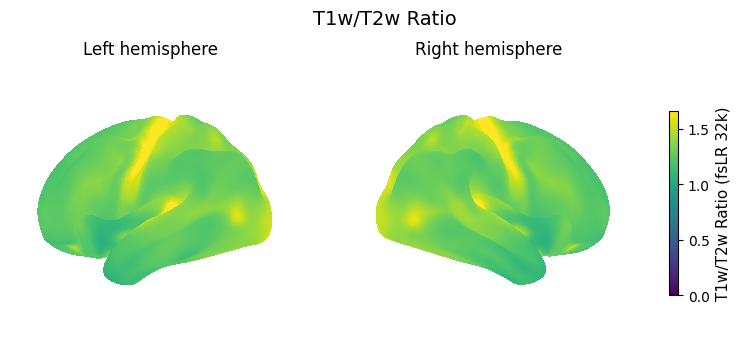

In [37]:
data = load_data(T1w_T2w_ratio)

vmin, vmax = np.percentile(data[~np.isnan(data)], [8, 98])

# Fetch fsLR 32k surfaces
fslr = fetch_atlas('fsLR', density='32k')
surf_l = fslr['inflated'].L
surf_r = fslr['inflated'].R

data_l = load_data(T1w_T2w_ratio[0])
data_r = load_data(T1w_T2w_ratio[1])

fig = plt.figure(figsize=(10, 4))

# left hemi
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_l,
    surf_map=data_l,
    hemi='left',
    view='lateral',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax1,
    title='Left hemisphere'
)

# right hemi
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_r,
    surf_map=data_r,
    hemi='right',
    view='lateral',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax2,
    title='Right hemisphere'
)

# color bar
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('T1w/T2w Ratio (fsLR 32k)', fontsize=11)

plt.suptitle("T1w/T2w Ratio", fontsize=14)
plt.show()


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2268535204.py:30: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2268535204.py:45: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


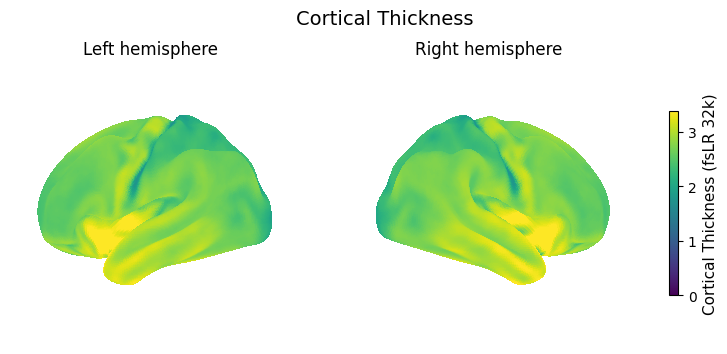

In [14]:
# plotting for cortical thickness
# fig = plotting.plot_surf_template(
#     data=cortical_thickness, # string of path to the data
#     template='fsLR',
#     density='32k',
#     surf='inflated',          
#     cmap='viridis',
#     hemi='R',
#     colorbar=True
# )
# fig.suptitle("Cortical Thickness (fsLR 32k)", fontsize=16, y=0.9)
# fig.show()

data = load_data(cortical_thickness)

vmin, vmax = np.percentile(data[~np.isnan(data)], [2, 98])

# Fetch fsLR 32k surfaces
fslr = fetch_atlas('fsLR', density='32k')
surf_l = fslr['inflated'].L
surf_r = fslr['inflated'].R

data_l = load_data(cortical_thickness[0])
data_r = load_data(cortical_thickness[1])

fig = plt.figure(figsize=(10, 4))

# left hemi
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_l,
    surf_map=data_l,
    hemi='left',
    view='lateral',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax1,
    title='Left hemisphere'
)

# right hemi
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_r,
    surf_map=data_r,
    hemi='right',
    view='lateral',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax2,
    title='Right hemisphere'
)

# color bar
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Cortical Thickness (fsLR 32k)', fontsize=11)

plt.suptitle("Cortical Thickness", fontsize=14)
plt.show()


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2324065245.py:38: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2324065245.py:44: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


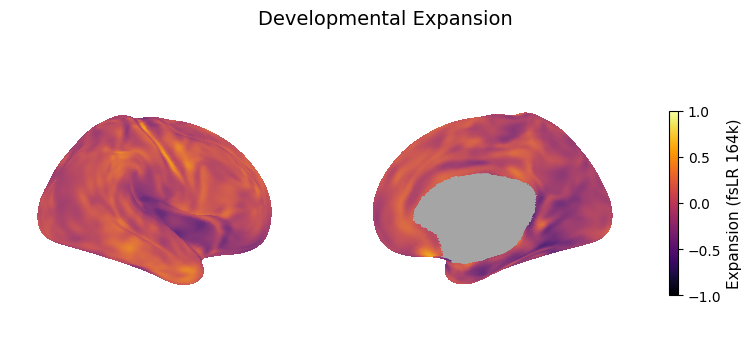

In [15]:
# plotting for devlopmental expansion
# fig = plotting.plot_surf_template(
#     data=dev_expansion,
#     template='fsLR',
#     density='164k',
#     surf='inflated',          
#     cmap='inferno',
#     hemi='R',
#     colorbar=True
# )
# fig.suptitle("Developmental Expansion (fsLR 164k)", fontsize=16, y=0.9)
# fig.show()

# load the data for the right hemi 
rh_data = load_data(dev_expansion)

# fetches brain surface options for plotting
fslr = fetch_atlas('fsLR', density='164k')
surf_r = fslr['inflated'].R # choose mid thickness for right hemi

vmin, vmax = -1, 1   # adjust if needed for better contrast

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_kwargs = dict(
    surf_mesh=surf_r,
    surf_map=rh_data,
    hemi='right',
    cmap='inferno',
    bg_on_data=True,
    vmin=vmin,
    vmax=vmax,
    colorbar=False
)
# plot right veiw
plotting.plot_surf(
    view='lateral',
    axes=ax1,
    **plot_kwargs
)
# plot from left view
plotting.plot_surf(
    view='medial',
    axes=ax2,
    **plot_kwargs
)

sm = plt.cm.ScalarMappable(cmap='inferno')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Expansion (fsLR 164k)', fontsize=11)
plt.suptitle("Developmental Expansion", fontsize=14)
plt.show()


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2806993922.py:31: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/2806993922.py:46: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


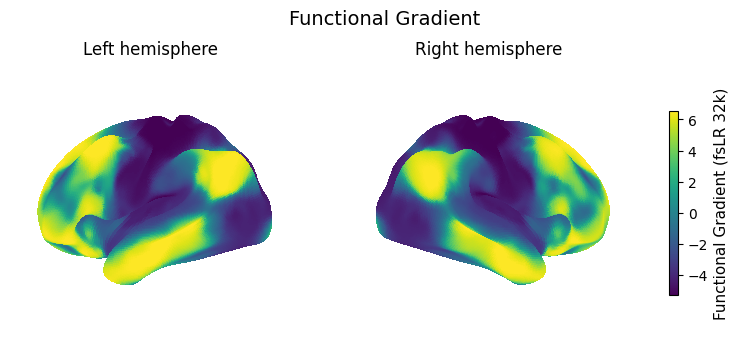

In [16]:
# plotting for functional gradient
# fig = plotting.plot_surf_template(
#     data=func_gradient,
#     template='fsLR',
#     density='32k',
#     surf='inflated',          
#     cmap='plasma',
#     hemi='R',
#     colorbar=True
#     # title='Gene PC1 Expression (fsaverage 10k)'
# )
# fig.suptitle("Functional Gradient(fsLR 32k)", fontsize=16, y=0.9)
# fig.show()

data = load_data(func_gradient)

vmin, vmax = np.percentile(data[~np.isnan(data)], [2, 98])

# Fetch fsLR 32k surfaces
fslr = fetch_atlas('fsLR', density='32k')
surf_l = fslr['inflated'].L
surf_r = fslr['inflated'].R

data_l = load_data(func_gradient[0])
data_r = load_data(func_gradient[1])

fig = plt.figure(figsize=(10, 4))

# left hemi
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_l,
    surf_map=data_l,
    hemi='left',
    view='lateral',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax1,
    title='Left hemisphere'
)

# right hemi
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_r,
    surf_map=data_r,
    hemi='right',
    view='lateral',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax2,
    title='Right hemisphere'
)

# color bar
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Functional Gradient (fsLR 32k)', fontsize=11)

plt.suptitle("Functional Gradient", fontsize=14)
plt.show()


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/1370601825.py:32: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_35443/1370601825.py:47: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


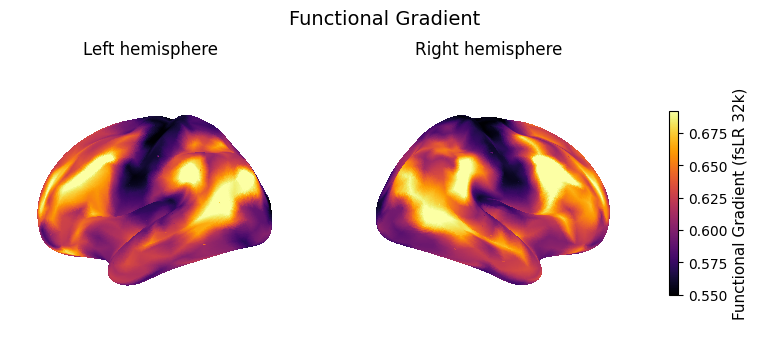

In [17]:
# plotting for intersubject variability
# fig = plotting.plot_surf_template(
#     data=intersub_var,
#     template='fsLR',
#     density='164k',
#     surf='inflated',          
#     cmap='inferno',
#     hemi='R',
#     colorbar=True
#     # title='Gene PC1 Expression (fsaverage 10k)'
# )
# fig.suptitle("Intersubject Variability(fsLR 32k)", fontsize=16, y=0.9)
# fig.show()


data = load_data(intersub_var)

vmin, vmax = np.percentile(data[~np.isnan(data)], [2, 98])

# Fetch fsLR 32k surfaces
fslr = fetch_atlas('fsLR', density='164k')
surf_l = fslr['inflated'].L
surf_r = fslr['inflated'].R

data_l = load_data(intersub_var[0])
data_r = load_data(intersub_var[1])

fig = plt.figure(figsize=(10, 4))

# left hemi
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_l,
    surf_map=data_l,
    hemi='left',
    view='lateral',
    cmap='inferno',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax1,
    title='Left hemisphere'
)

# right hemi
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_r,
    surf_map=data_r,
    hemi='right',
    view='lateral',
    cmap='inferno',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax2,
    title='Right hemisphere'
)

# color bar
sm = plt.cm.ScalarMappable(cmap='inferno')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Functional Gradient (fsLR 32k)', fontsize=11)

plt.suptitle("Functional Gradient", fontsize=14)
plt.show()


In [18]:
## results dictionary
# for box plot for later

results_dict = {'target map':[], 
                'r_emp':[], 
                'p_spin':[], 
                'nulls':[]
               }

In [19]:
## Code for PC1 Gene Expression correlation with source map

# transform source map to fsaverage 10k
evo_in_fsaverage10k = transforms.fslr_to_fsaverage(evo_map, '10k', hemi='R')
# load the data --> bascially reads in the .func.gii file and returns the data array
evo_data = load_data(evo_in_fsaverage10k[0]) # load_data([path where string of the data file])
genepc1_data = load_data(genepc1[1]) # right hemi

# make left hemi NaN's so spin test works for built in function
evo_full = np.concatenate([np.full_like(evo_data, np.nan), evo_data])
genepc1_full = np.concatenate([np.full_like(genepc1_data, np.nan), genepc1_data])
print(f"evo_fill shape: {evo_full.shape}")

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(genepc1_full)
r_emp, _ = pearsonr(evo_full[mask], genepc1_full[mask])
print(f"Empirical correlation = {r_emp:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fsaverage',
    density='10k',
    n_perm=1000
)

# empirical r to null
# compare_images() compares the two maps and the nulls --> outputs r, p value, and null distribution
r_emp_gene, p_spin_gene, nulls_gene = compare_images(
    evo_full,
    genepc1_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True # null distribution for boxplot later
)
print(f"Spatial correlation for Gene Expression = {r_emp_gene:.3f}, spin test p = {p_spin_gene:.4f}")

#---------------
results_dict['target map'].append('PC1 Gene Expression')
results_dict['r_emp'].append(r_emp_gene)
results_dict['p_spin'].append(p_spin_gene)
results_dict['nulls'].append(nulls_gene)

evo_fill shape: (20484,)
Empirical correlation = -0.510
Spatial correlation for Gene Expression = -0.512, spin test p = 0.0280


In [20]:
results_dict['target map']

['PC1 Gene Expression']

In [21]:
# data check
evo_full

array([       nan,        nan,        nan, ..., 1.3517373 , 1.1653305 ,
       0.99199647], shape=(20484,), dtype=float32)

In [22]:
# Sanity check
fslr = fetch_atlas('fsLR', density='32k')
# fslr = fetch_atlas('fsaverage', density='10k')
fslr

{'midthickness': Surface(L=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii'), R=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-R_midthickness.surf.gii')),
 'inflated': Surface(L=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_inflated.surf.gii'), R=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-R_inflated.surf.gii')),
 'veryinflated': Surface(L=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_veryinflated.surf.gii'), R=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-R_veryinflated.surf.gii')),
 'sphere': Surface(L=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_sphere.surf.gii'), R=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-R_sphere.surf.gii')),
 'medial': Surface(L=PosixPath('/Users/kevin/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_desc-

In [24]:
### TEST TO USE FSLR 32K FOR EVO MAP TO MATCH MYELIN MAP
## it Works

# transform source map to fsaverage 10k
evo_in_fsLR = transforms.fslr_to_fslr(evo_map, '32k', hemi='R') ## (<nibabel.gifti.gifti.GiftiImage at 0x3156bff10>,)
# load the data --> bascially reads in the .func.gii file and returns the data array
evo_data = load_data(evo_in_fsLR[0]) # load_data([path where string of the data file])
T1w_T2w_ratio_data = load_data(T1w_T2w_ratio) 

# make left hemi NaN's so spin test works for built in function
evo_full = np.concatenate([np.full_like(evo_data, np.nan), evo_data])
myelin_full = T1w_T2w_ratio_data
print(f"evo_fill shape: {evo_full.shape}")

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(myelin_full)
r_emp_prelim, _ = pearsonr(evo_full[mask], myelin_full[mask])
print(f"Empirical correlation = {r_emp_prelim:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fslr',
    density='32k',
    n_perm=1000
)

# empirical r to null
# compare_images() compares the two maps and the nulls --> outputs r, p value, and null distribution
r_emp, p_spin, nulls_dist = compare_images(
    evo_full,
    myelin_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True # null distribution for boxplot later
)
print(f"Spatial correlation for Gene Expression = {r_emp:.3f}, spin test p = {p_spin:.4f}")

#---------------
results_dict['target map'].append('T1w/T2w Ratio')
results_dict['r_emp'].append(r_emp)
results_dict['p_spin'].append(p_spin)
results_dict['nulls'].append(nulls_dist)

evo_fill shape: (64984,)
Empirical correlation = -0.040
Spatial correlation for Gene Expression = -0.465, spin test p = 0.0080


In [25]:
results_dict['target map']

['PC1 Gene Expression', 'T1w/T2w Ratio']

In [26]:
# permuted
# # 1000 rows, each row is coordinate points for each spun map

In [28]:
### TEST TO USE FSLR 32K FOR EVO MAP TO MATCH CORTICAL THICKNESS

# transform source map to fsaverage 10k
evo_in_fsLR = transforms.fslr_to_fslr(evo_map, '32k', hemi='R') ## (<nibabel.gifti.gifti.GiftiImage at 0x3156bff10>,)
# load the data --> bascially reads in the .func.gii file and returns the data array
evo_data = load_data(evo_in_fsLR[0]) # load_data([path where string of the data file])
target_data = load_data(cortical_thickness) 

# make left hemi NaN's so spin test works for built in function
evo_full = np.concatenate([np.full_like(evo_data, np.nan), evo_data])
genepc1_full = target_data  # np.concatenate([np.full_like(T1w_T2w_ratio_data, np.nan), T1w_T2w_ratio_data])
print(f"evo_fill shape: {evo_full.shape}")

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(genepc1_full)
r_emp_prelim, _ = pearsonr(evo_full[mask], genepc1_full[mask])
print(f"Empirical correlation = {r_emp_prelim:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fslr',
    density='32k',
    n_perm=1000
)

# empirical r to null
# compare_images() compares the two maps and the nulls --> outputs r, p value, and null distribution
r_emp, p_spin_gene, nulls_dist = compare_images(
    evo_full,
    genepc1_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True # null distribution for boxplot later
)
print(f"Spatial correlation for Gene Expression = {r_emp:.3f}, spin test p = {p_spin_gene:.4f}")

#---------------
results_dict['target map'].append('Cortical Thickness')
results_dict['r_emp'].append(r_emp)
results_dict['p_spin'].append(p_spin_gene)
results_dict['nulls'].append(nulls_dist)
results_dict['target map']

evo_fill shape: (64984,)
Empirical correlation = 0.247
Spatial correlation for Gene Expression = 0.315, spin test p = 0.1269


['PC1 Gene Expression', 'T1w/T2w Ratio', 'Cortical Thickness']

In [29]:
## Functional Gradient
### TEST TO USE FSLR 32K FOR EVO MAP TO MATCH FUNCTIONAL GRADIENT

# transform source map to fsaverage 10k
evo_in_fsLR = transforms.fslr_to_fslr(evo_map, '32k', hemi='R') ## (<nibabel.gifti.gifti.GiftiImage at 0x3156bff10>,)
# load the data --> bascially reads in the .func.gii file and returns the data array
evo_data = load_data(evo_in_fsLR[0]) # load_data([path where string of the data file])
T1w_T2w_ratio_data = load_data(func_gradient) 

# make left hemi NaN's so spin test works for built in function
evo_full = np.concatenate([np.full_like(evo_data, np.nan), evo_data])
genepc1_full = T1w_T2w_ratio_data  # np.concatenate([np.full_like(T1w_T2w_ratio_data, np.nan), T1w_T2w_ratio_data])
print(f"evo_fill shape: {evo_full.shape}")

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(genepc1_full)
r_emp, _ = pearsonr(evo_full[mask], genepc1_full[mask])
print(f"Empirical correlation = {r_emp:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fslr',
    density='32k',
    n_perm=1000
)

# empirical r to null
# compare_images() compares the two maps and the nulls --> outputs r, p value, and null distribution
r_emp_gene, p_spin_gene, nulls_gene = compare_images(
    evo_full,
    genepc1_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True # null distribution for boxplot later
)
print(f"Spatial correlation for Gene Expression = {r_emp_gene:.3f}, spin test p = {p_spin_gene:.4f}")

#---------------
results_dict['target map'].append('Functional Gradient')
results_dict['r_emp'].append(r_emp_gene)
results_dict['p_spin'].append(p_spin_gene)
results_dict['nulls'].append(nulls_gene)
results_dict['target map']

evo_fill shape: (64984,)
Empirical correlation = 0.334
Spatial correlation for Gene Expression = 0.341, spin test p = 0.0759


['PC1 Gene Expression',
 'T1w/T2w Ratio',
 'Cortical Thickness',
 'Functional Gradient']

In [30]:
results_dict['target map']

['PC1 Gene Expression',
 'T1w/T2w Ratio',
 'Cortical Thickness',
 'Functional Gradient']

In [31]:
## Intersubject Variability
# note: takes about 15-20 min to run

start_time = time.time()

# both are in the same dimension already --> no need to transform
evo_data_r = load_data(evo_map)
ISV_r = load_data(intersub_var) # right hemi

# make left hemi NaN's so spin test works
evo_full = np.concatenate([np.full_like(evo_data_r, np.nan), evo_data_r])
ISV_full = ISV_r #np.concatenate([np.full_like(ISV_r, np.nan), ISV_r])

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(ISV_full)
r_emp, _ = pearsonr(evo_full[mask], ISV_full[mask])
print(f"Empirical correlation = {r_emp:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fsLR',
    density='164k',
    n_perm=1000
)

# empirical r to null
r_emp_ISV, p_spin_ISV, nulls_ISV = compare_images(
    evo_full,
    ISV_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True
)
print(f"Spatial correlation for Intersubject Variability = {r_emp_ISV:.3f}, spin test p = {p_spin_ISV:.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total time to run: {(total_time/60):.2f} minutes")

#---------------
results_dict['target map'].append('Intersubject Variability')
results_dict['r_emp'].append(r_emp_ISV)
results_dict['p_spin'].append(p_spin_ISV)
results_dict['nulls'].append(nulls_ISV)
results_dict['target map']

Empirical correlation = 0.575
Spatial correlation for Intersubject Variability = 0.575, spin test p = 0.0040
Total time to run: 15.17 minutes


['PC1 Gene Expression',
 'T1w/T2w Ratio',
 'Cortical Thickness',
 'Functional Gradient',
 'Intersubject Variability']

In [33]:
start_time = time.time()

## og code for developmental expansion
# note: takes about 15-20 min to run

# both are from Hill (164k) and both only have right hemi data
evo_data_r = load_data(evo_map)
dev_expansion_r = load_data(dev_expansion)

# make left hemi NaN's so spin test works
evo_full = np.concatenate([np.full_like(evo_data_r, np.nan), evo_data_r])
dev_expansion_full = np.concatenate([np.full_like(dev_expansion_r, np.nan), dev_expansion_r])

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(dev_expansion_full)
r_emp, _ = pearsonr(evo_full[mask], dev_expansion_full[mask])
print(f"Empirical correlation = {r_emp:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fsLR',
    density='164k',
    n_perm=1000
)

# empirical r to null
r_emp_dev_exp, p_spin_dev_exp, nulls_dev = compare_images( # nan_policy: str = 'omit'
    evo_full,
    dev_expansion_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True
)
print(f"Spatial correlation for Gene Expression = {r_emp_dev_exp:.3f}, spin test p = {p_spin_dev_exp:.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total time to run: {(total_time/60):.2f} minutes")
#---------------
results_dict['target map'].append('Developmental Expansion')
results_dict['r_emp'].append(r_emp_dev_exp)
results_dict['p_spin'].append(p_spin_dev_exp)
results_dict['nulls'].append(nulls_dev)
results_dict['target map']

Empirical correlation = 0.354
Spatial correlation for Gene Expression = 0.354, spin test p = 0.0190
Total time to run: 53.70 minutes


['PC1 Gene Expression',
 'T1w/T2w Ratio',
 'Cortical Thickness',
 'Functional Gradient',
 'Intersubject Variability',
 'Developmental Expansion']

## Box plots
Null distributions and pearson r

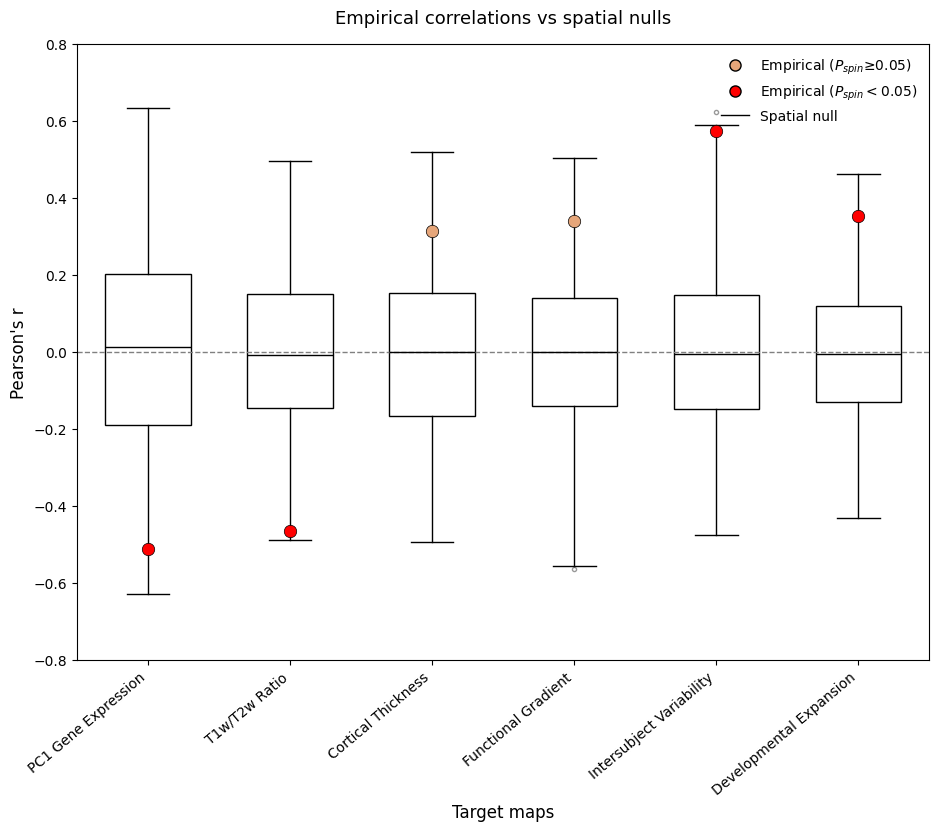

In [34]:
## Plotting box plots

# for target, nulls, r, p in zip(results_dict['target map'],
#                                results_dict['nulls'],
#                                results_dict['r_emp'],
#                                results_dict['p_spin']):

#     # make into 1D arrays
#     nulls = np.ravel(np.array(nulls))
#     nulls = nulls[~np.isnan(nulls)]
#     color = 'red' if p < 0.05 else 'orange'

#     plt.figure(figsize=(6, 6))
#     plt.boxplot(nulls, vert=True, widths=0.5, boxprops=dict(color='black'))

#     plt.scatter(1, r, color=color, s=80, zorder=3,
#                 label=f'Empirical r (p={p:.4f})')

#     plt.title(f"Spin Test Null Distribution — {target}")
#     plt.ylabel("Pearson's r")
#     plt.xticks([])
#     plt.grid(alpha=0.2)
#     plt.legend()

#     plt.show()

## code for box plots all together

results_df = pd.DataFrame(results_dict)

# check to make sure it's 1D array and not 2D
box_data = [np.ravel(np.array(n)) for n in results_df['nulls']]
positions = np.arange(1, len(box_data) + 1)

fig, ax = plt.subplots(figsize=(11, 8))

# boxplots for null dist
bp = ax.boxplot(
    box_data,
    positions=positions,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
    medianprops=dict(color='black', linewidth=1),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', color='gray', markersize=3, alpha=0.4)
)

# add pearson r points
for i, (r, p) in enumerate(zip(results_df['r_emp'], results_df['p_spin'])):
    color = 'red' if p < 0.05 else '#e6a67a'
    ax.scatter(
        positions[i],
        r,
        color=color,
        s=80,
        edgecolor='black',
        linewidth=0.5,
        zorder=3
    )

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xticks(positions)
ax.set_xticklabels(results_df['target map'], rotation=40, ha='right', fontsize=10)
ax.set_ylabel("Pearson's r", fontsize=12)
ax.set_xlabel("Target maps", fontsize=12)
ax.set_ylim(-0.8, 0.8)
ax.set_title("Empirical correlations vs spatial nulls", fontsize=13, pad=15)

# legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Empirical ($P_{spin} ≥ 0.05$)',
           markerfacecolor='#e6a67a', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Empirical ($P_{spin} < 0.05$)',
           markerfacecolor='red', markeredgecolor='black', markersize=8),
    Line2D([0], [0], color='black', lw=1, label='Spatial null')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.show()

In [35]:
# # Used to clean up duplicate target maps in results_dict
# # Find all indices where target == 'PC1 Gene Expression'
# # indices = [i for i, t in enumerate(results_dict['target map']) if t == 'PC1 Gene Expression']
# # indices = [i for i, t in enumerate(results_dict['target map']) if t == 'Intersubject Variability']
# indices = [i for i, t in enumerate(results_dict['target map']) if t == 'Developmental Expansion']

# # keep the newest version of target map
# if len(indices) > 1:
#     # get all but the last
#     to_remove = indices[:-1]

#     # remove from each list in the dictionary (in reverse order so indices don't shift)
#     for idx in sorted(to_remove, reverse=True):
#         for key in results_dict:
#             del results_dict[key][idx]

# print("cleaned results_dict")
# print(results_dict['target map'])

#### False Discovery Rate

In [36]:
# from neuromaps.stats import fdr_correct
p_vals = np.array(results_dict['p_spin'])
reject, p_fdr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

results_dict['p_fdr'] = p_fdr
results_dict['reject'] = reject

summary_df = pd.DataFrame({
    'Target map': results_dict['target map'],
    'p_spin (uncorrected)': results_dict['p_spin'],
    'p_FDR (corrected)': p_fdr,
    'Significant (FDR<0.05)': reject
})

summary_df = summary_df.round(4)
print("Summary of results:")
summary_df

Summary of results:


,Target map,p_spin (uncorrected),p_FDR (corrected),Significant (FDR<0.05)
0,PC1 Gene Expression,0.0280,0.0420,True
1,T1w/T2w Ratio,0.0080,0.0240,True
2,Cortical Thickness,0.1269,0.1269,False
3,Functional Gradient,0.0759,0.0911,False
4,Intersubject Variability,0.0040,0.0240,True
5,Developmental Expansion,0.0190,0.0380,True


### Testing other target map colors
to find the right one

'cbf': {'cmap': 'inferno', 'vmin': None, 'vmax': None}, # need to change
'cmr02': {'cmap': 'inferno', 'vmin': None, 'vmax': None}, # need to change
'cmrglc': {'cmap': 'inferno', 'vmin': None, 'vmax': None}, # need to change


In [5]:
cbf = fetch_annotation(source='raichle', desc='cbf', space='fsLR',den='164k')
cmr_02 = fetch_annotation(source='raichle', desc='cmr02', space='fsLR',den='164k')
cmr_glc = fetch_annotation(source='raichle', desc='cmrglc', space='fsLR',den='164k') 


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbf', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmr02', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164

/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_79139/167738686.py:24: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_79139/167738686.py:35: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


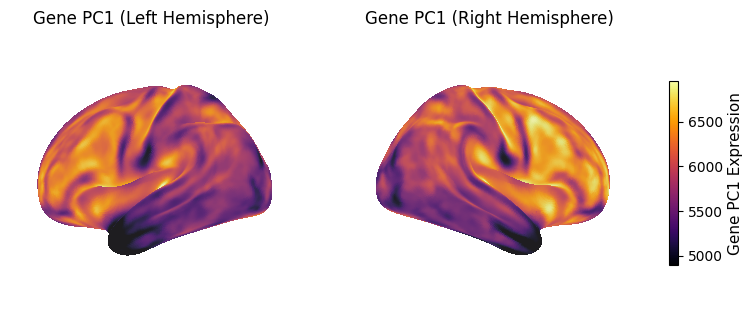

In [15]:
# fetch brain meshes of density 10k for plotting
fsavg = fetch_atlas('fsLR', '164k')

# load data from GIFTI files
lh_data = load_data(cbf[0])
rh_data = load_data(cbf[1])
data_full = np.concatenate([lh_data, rh_data])

# vmin, vmax = 5000, 6500   # adjust if needed for better contrast
vmin, vmax = np.percentile(data_full[~np.isnan(data_full)], [10, 98])

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_kwargs = dict(
    cmap='inferno',
    bg_on_data=True,
    vmin=vmin, vmax=vmax,
    colorbar=False
)

# left hemi
plotting.plot_surf(
    surf_mesh=fsavg['inflated'].L,
    surf_map=lh_data,
    hemi='left',
    view='lateral',
    axes=ax1,
    title='Gene PC1 (Left Hemisphere)',
    **plot_kwargs
)

# right hemi
plotting.plot_surf(
    surf_mesh=fsavg['inflated'].R,
    surf_map=rh_data,
    hemi='right',
    view='lateral',
    axes=ax2,
    title='Gene PC1 (Right Hemisphere)',
    **plot_kwargs
)
# colorbar for both plots
sm = plt.cm.ScalarMappable(cmap='inferno')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Gene PC1 Expression', fontsize=11)
# cbar.set_ticks([vmin, 0, vmax])

plt.show()